In [11]:
import xarray as xr
from fsspec.implementations.http import HTTPFileSystem

The dataset can be accessed directly with `xarray` using `kerchunks`' `HTTPFileSystem`: This creates a virtual filesystem that maps the zarr chunks and metadata to HTTP endpoints running on XREDS

In [14]:
# We can access our API using fsspec's HTTPFileSystem
fs = HTTPFileSystem()

# The http mapper gives us a dict-like interface to the API
http_map = fs.get_mapper("http://localhost:8090/datasets/dbofs/zarr")

ds = xr.open_zarr(http_map, consolidated=True)
ds

<xarray.Dataset>
Dimensions:        (ocean_time: 804, tracer: 2, s_rho: 10, s_w: 11,
                    boundary: 4, eta_rho: 732, xi_rho: 119, eta_psi: 731,
                    xi_psi: 118, eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2023-05-26T01:00:00 ... 2023-0...
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/78)
    Akk_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r           (ocean_time, s_rho) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    Cs_w           (ocean_time, s_w) float64 dask.array<chunksize=(1, 11), meta=np.ndarray>
    ...             ...
    theta_s        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u              (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 732, 118), meta=np.ndarray>
    v              (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 731, 119), meta=np.ndarray>
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 6, 732, 119), meta=np.ndarray>
    xl             (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230526.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

We can plot the entire temperature variable at a specific time and depth using `matplotlib`

CPU times: user 80.3 ms, sys: 9.55 ms, total: 89.9 ms
Wall time: 96.3 ms


/Users/matthewiannucci/Developer/aggregate_ofs/env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


(-8652876.920232963, -8155728.577340467, 4526450.29397872, 4868634.279372582)

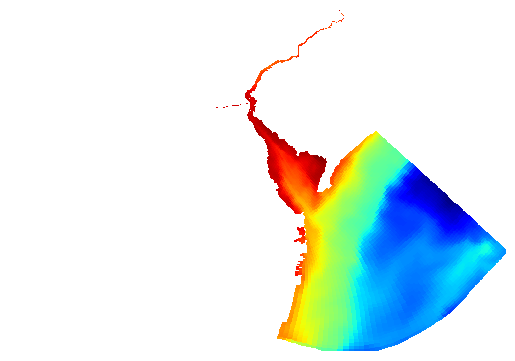

In [24]:
%%time 

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

sst = ds.temp.isel(ocean_time=0, s_rho=0).values

lng = ds.lon_rho.load()
lat = ds.lat_rho.load()

# plt.pcolormesh(ds.lon_rho, ds.lat_rho, temp)
ax = plt.axes(projection=ccrs.Mercator())
plt.pcolormesh(lng, lat, sst, transform=ccrs.PlateCarree(), cmap='jet')
ax.set_extent([lng.min(), lng.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.axis('off')

In [9]:
%%time

import numpy as np
import matplotlib.tri as tri

x = ds.lon_rho.values.flatten()
y = ds.lat_rho.values.flatten()
z = ds.temp.isel(ocean_time=-2, s_rho=0).values.flatten()

# triang = tri.Triangulation(x, y)
# data_tris = z[triang.triangles]
# mask = np.where(np.isnan(data_tris), [True], [False])
# triangle_mask = np.any(mask, axis=1)
# triang.set_mask(triangle_mask)

CPU times: user 28.8 ms, sys: 14.6 ms, total: 43.4 ms
Wall time: 1.16 s


CPU times: user 9.49 s, sys: 153 ms, total: 9.64 s
Wall time: 9.72 s


(-8652876.920232963, -8155728.577340467, 4526450.29397872, 4868634.279372582)

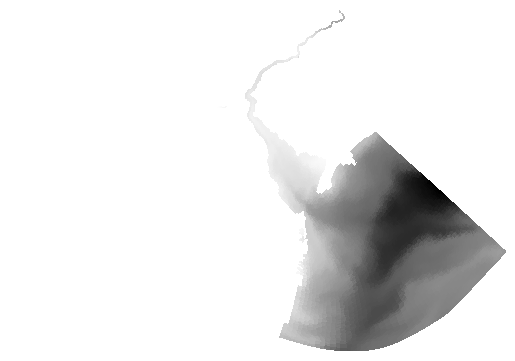

In [75]:
%%time
ax = plt.axes(projection=ccrs.Mercator())
ax.tripcolor(triang, z, cmap='Greys_r', transform=ccrs.PlateCarree())
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
ax.axis('off')

CPU times: user 224 ms, sys: 6.75 ms, total: 231 ms
Wall time: 239 ms


(-8652876.920232963, -8155728.577340467, 4526450.29397872, 4868634.279372582)

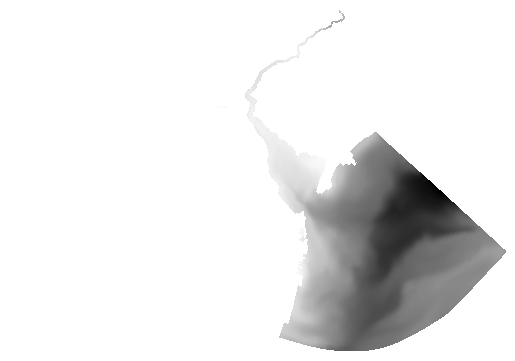

In [77]:
%%time
ax = plt.axes(projection=ccrs.Mercator())
ax.tricontourf(triang, z, cmap='Greys_r', transform=ccrs.PlateCarree(), levels=200)
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
ax.axis('off')

In [29]:
import cf_xarray
ds.temp.cf.dim['latitude']

AttributeError: 'dim' is not a valid attribute on the underlying xarray object.

In [78]:
t = f'{ds.cf}'.startswith('SGRID')


In [93]:
ds.lon_rho.values

array([[ 1.29420523e-309,              nan,  1.15438693e-309, ...,
                     nan,              nan,              nan],
       [ 8.67174800e-310,              nan,  7.96215261e-310, ...,
         1.12694952e-309,  1.12045622e-309,  4.63549981e-310],
       [             nan,              nan,  1.01995850e-309, ...,
         5.50530588e-310,  7.67313678e-311,  4.66605654e-310],
       ...,
       [ 2.62363142e-314,  6.85627436e-162,  2.62369056e-314, ...,
         2.62369240e-314,  2.62369243e-314, -3.78557061e+297],
       [ 2.62369246e-314,  2.62366648e-314, -2.65814919e+227, ...,
         1.13881833e-045,  2.62369448e-314,  2.62363165e-314],
       [-2.18556148e-105,  2.62369451e-314,  2.62363170e-314, ...,
         2.62366743e-314,  7.64677557e-220,  2.62369638e-314]])